## Imports

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

## Functions

In [265]:
# Chirikov standard map
def generateChirikovMap(xo, yo, iter, delta, to):
    x = []
    y = []
    for i in range(iter+to):
        x1 = (xo+yo)%(2*math.pi)
        y1 = (xo+delta*math.sin(xo+yo))%(2*math.pi)
        xo = x1
        yo = y1
        if i>=to:
            x.append(x1)
            y.append(y1)
    return x,y

def inverseChirikovMap(x_, y_, iter, delta, to):
    x = []
    y = []
    for i in range(iter):
        


## Image Inputs

In [484]:
image = cv2.imread('./img.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1536, 2048, 3)

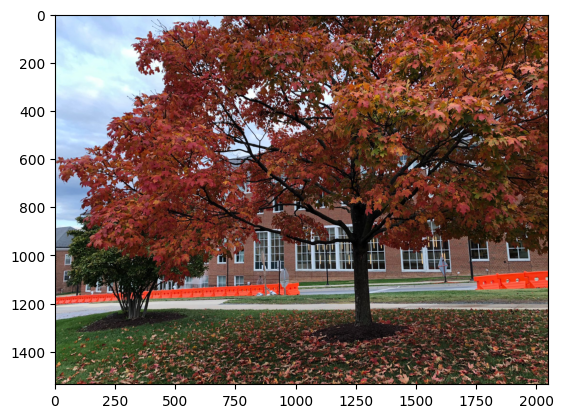

In [485]:
imgplot = plt.imshow(image)

## Image Encryption 

In [530]:
I1 = image[:,:,0]
I2 = image[:,:,1]
I3 = image[:,:,2]

In [531]:
print(I1.shape)
print(I2.shape)
print(I3.shape)

(1536, 2048)
(1536, 2048)
(1536, 2048)


In [532]:
M = I1.shape[0]
N = I1.shape[1]

In [533]:
# Generate chaotic chirikov map for vertical shift
x,y1 = generateChirikovMap(0.1, 0.1, 3*M, 0.1, 1000)
# plot1 = plt.plot(x,y1)
x = np.array(x)
print(len(x))
x1,y = generateChirikovMap(0.1, 0.1, N, 0.1, 1000)
# plot2 = plt.plot(x1,y)
y = np.array(y)
print(len(y))

4608
2048


In [534]:
# Generated chaotic sequence for encryption
X = np.floor(x*1e14)%N
Y = np.floor(y*1e14)%(3*M)

In [535]:
print(X.shape)
print(Y.shape)

(4608,)
(2048,)


In [536]:
# Combining the three indexed images
F_e = np.concatenate((I1, I2, I3))
F_e.shape

(4608, 2048)

In [537]:
# Performing right shift in dimension N
for i in range(len(X)):
    row = F_e[i,:]
    F_e[i,:] = np.roll(row, int(X[i]))

In [538]:
# Performing bottom shift in dimension 3M
for j in range(len(Y)):
    column = F_e[:,j]
    F_e[:,j] = np.roll(column, int(Y[j]))

In [539]:
# Decomposing the scrambled image into three channels
F1 = F_e[0:M, :]
F2 = F_e[M:2*M, :]
F3 = F_e[2*M:3*M, :]

In [540]:
# Horizontal concatenation of the three channels
F_dashe = np.concatenate((F1, F2, F3), axis=1)

In [541]:
F_check1 = F_dashe

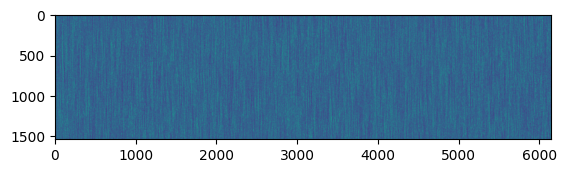

In [542]:
# After performing right shift the encrypted image is 
encrypt1 = plt.imshow(F_dashe)

In [543]:
F_dashe.shape

(1536, 6144)

In [544]:
# Generate chaotic chirikov map for vertical shift
x,_ = generateChirikovMap(0.1, 0.1, M, 0.1, 1000)
x = np.array(x)
print(len(x))
_,y = generateChirikovMap(0.1, 0.1, 3*N, 0.1, 1000)
y = np.array(y)
print(len(y))

1536
6144


In [545]:
X = np.floor(x*1e14)%(3*N)
Y = np.floor(y*1e14)%M

In [546]:
# Performing bottom shift in dimension N
for i in range(len(X)):
    row = F_dashe[i,:]
    F_dashe[i,:] = np.roll(row, int(X[i]))

In [547]:
# Performing bottom shift in dimension M
for j in range(len(Y)):
    column = F_dashe[:,j]
    F_dashe[:,j] = np.roll(column, int(Y[j]))

In [548]:
F_dashe.shape

(1536, 6144)

In [549]:
C1 = F_dashe[:, 0:N]
C2 = F_dashe[:, N:2*N]
C3 = F_dashe[:, 2*N:3*N]

In [550]:
print(C1.shape)
print(C2.shape)
print(C3.shape)

(1536, 2048)
(1536, 2048)
(1536, 2048)


In [551]:
# Encrypted image
E = np.zeros((M, N, 3), dtype=np.uint8)
E[:,:,0] = C1
E[:,:,1] = C2
E[:,:,2] = C3

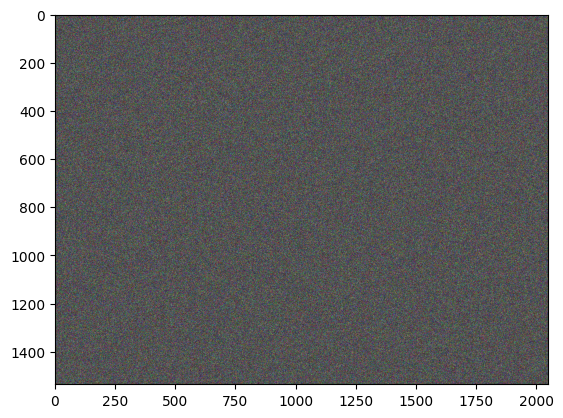

In [552]:
encrypted = plt.imshow(E)

### Chirikov decryption

In [561]:
# chirikov encrypted image
C1 = E[:,:,0]
C2 = E[:,:,1]
C3 = E[:,:,2]

F_dash = np.concatenate([C1,C2,C3], axis=1)
print(F_dash.shape)

(1536, 6144)


In [562]:
xo = 0.1 
yo = 0.1
# Generate chaotic chirikov map for vertical shift
x,_ = generateChirikovMap(xo, yo, M, 0.1, 1000)
x = np.array(x)
print(len(x))
_,y = generateChirikovMap(xo, yo, 3*N, 0.1, 1000)
y = np.array(y)
print(len(y))
X = np.floor(x*1e14)%(3*N)
Y = np.floor(y*1e14)%M

1536
6144


In [563]:
# Performing bottom shift in dimension M
for j in range(len(Y)):
    column = F_dash[:,j]
    F_dash[:,j] = np.roll(column, int(Y[j]))

In [564]:
# Performing bottom shift in dimension N
for i in range(len(X)):
    row = F_dash[i,:]
    F_dash[i,:] = np.roll(row, int(X[i]))

array([[ 45, 185,  35, ..., 243,   3,  48],
       [214,  67, 244, ..., 238, 112, 124],
       [  9, 223, 147, ...,  85,  55, 200],
       ...,
       [110,   7, 222, ...,  41,  10,  88],
       [215,  28, 120, ...,  60, 211, 235],
       [ 15, 244, 205, ...,  48, 221,  27]], dtype=uint8)

In [439]:
F1_dash = F_dash[:,0:N]
F2_dash = F_dash[:,N:2*N]
F3_dash = F_dash[:,2*N:3*N]
F = np.concatenate([F1_dash, F2_dash, F2_dash])

In [440]:
# Generate chaotic chirikov map for vertical shift
x,y1 = generateChirikovMap(0.1, 0.1, 3*M, 0.1, 1000)
# plot1 = plt.plot(x,y1)
x = np.array(x)
print(len(x))
x1,y = generateChirikovMap(0.1, 0.1, N, 0.1, 1000)
# plot2 = plt.plot(x1,y)
y = np.array(y)
print(len(y))

4608
2048


In [442]:
# Generated chaotic sequence for encryption
X = np.floor(x*1e14)%N
Y = np.floor(y*1e14)%(3*M)

In [443]:
# Performing bottom shift in dimension 3M
for j in range(len(Y)):
    column = F[:,j]
    F[:,j] = np.roll(column, -int(Y[j]))

In [444]:
# Performing right shift in dimension N
for i in range(len(X)):
    row = F[i,:]
    F[i,:] = np.roll(row, -int(X[i]))

In [445]:
ch1 = F[:M,:]
ch2 = F[M:2*M,:]
ch3 = F[2*M:3*M,:]

In [447]:
decrypted = np.zeros((ch1.shape[0],ch1.shape[1],3), dtype=np.int16)
decrypted[:,:,0] = ch1
decrypted[:,:,1] = ch2
decrypted[:,:,2] = ch3 

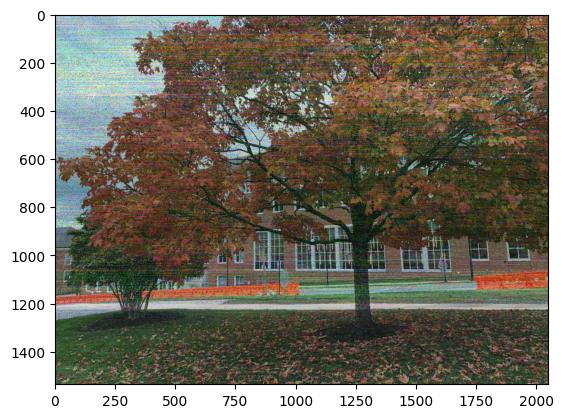

In [448]:
im_plot = plt.imshow(decrypted)

## Image Decryption

In [323]:
# initial values 
xo_ = 0.1
yo_ = 0.1
x_dash,_ = generateChirikovMap(xo_, yo_, M//2, 0.1, 1000)
x_dash = np.array(x_dash)/math.pi
_,y_dash = generateChirikovMap(xo_, yo_, N//2, 0.1, 1000)
y_dash = np.array(y_dash)/math.pi

In [324]:
print(x_dash.shape)
print(y_dash.shape)

(768,)
(1024,)


In [325]:
x_dash

array([1.73034214, 1.5973919 , 1.29738139, 0.86917627, 0.17927483,
       1.06544573, 1.23822201, 0.28200788, 1.54488358, 1.79537638,
       1.3211781 , 1.08961575, 0.4019502 , 1.52189871, 1.89209322,
       1.40340675, 1.26512336, 0.64497861, 1.93868801, 0.57757327,
       0.5471517 , 1.15620736, 1.68835779, 0.8181464 , 0.5237163 ,
       1.37360538, 1.86796733, 1.22874482, 1.07575626, 0.29699676,
       1.39832716, 1.66510296, 1.03578582, 0.69731773, 1.7590121 ,
       0.43446811, 0.22463901, 0.67975223, 0.9312803 , 1.61785124,
       0.5194574 , 0.16908018, 0.70466164, 0.89921687, 1.61378927,
       0.48318746, 0.12876333, 0.62447881, 0.78267004, 1.42723224,
       0.17889944, 1.62309455, 1.7725136 , 1.37474715, 1.11786244,
       0.48109083, 1.6307281 , 0.08263489, 1.72153397, 1.77974072,
       1.48096489, 1.22893152, 0.68892647, 1.94424498, 0.62762441,
       0.60117595, 1.25903689, 1.83707508, 1.08052161, 0.90963014,
       1.99906782, 0.90860474, 0.91668703, 1.83352827, 0.73431

In [326]:
for i in range(len(x_dash)):
    if x_dash[i]>1:
        x_dash[i] = 1
    else:
        x_dash[i] = 0
for j in range(len(y_dash)):
    if y_dash[j]>1:
        y_dash[j] = 1
    else:
        y_dash[j] = 0

In [332]:
q1 = x_dash
q2 = y_dash

In [ ]:
alpha = 0.68
beta = 0.72
